# 1. Loading Libraries and Data

In [34]:
library(ggplot2)
library(tidyverse)
library(GGally)

In [35]:
library(caret)
library(randomForest)
library(rpart)
# library(stats)

In [36]:
data <- read.csv("expenses.csv")

# 2. Data Preprocessing

In [37]:
summary(data)

      age            sex                 bmi           children    
 Min.   :18.00   Length:1338        Min.   :15.96   Min.   :0.000  
 1st Qu.:27.00   Class :character   1st Qu.:26.30   1st Qu.:0.000  
 Median :39.00   Mode  :character   Median :30.40   Median :1.000  
 Mean   :39.21                      Mean   :30.66   Mean   :1.095  
 3rd Qu.:51.00                      3rd Qu.:34.69   3rd Qu.:2.000  
 Max.   :64.00                      Max.   :53.13   Max.   :5.000  
    smoker             region             charges     
 Length:1338        Length:1338        Min.   : 1122  
 Class :character   Class :character   1st Qu.: 4740  
 Mode  :character   Mode  :character   Median : 9382  
                                       Mean   :13270  
                                       3rd Qu.:16640  
                                       Max.   :63770  

In [38]:
str(data)

'data.frame':	1338 obs. of  7 variables:
 $ age     : int  19 18 28 33 32 31 46 37 37 60 ...
 $ sex     : chr  "female" "male" "male" "male" ...
 $ bmi     : num  27.9 33.8 33 22.7 28.9 ...
 $ children: int  0 1 3 0 0 0 1 3 2 0 ...
 $ smoker  : chr  "yes" "no" "no" "no" ...
 $ region  : chr  "southwest" "southeast" "southeast" "northwest" ...
 $ charges : num  16885 1726 4449 21984 3867 ...


In [39]:
# converting categorical variables to factor
data$sex <- as.factor(data$sex)
data$smoker <- as.factor(data$smoker)
data$region <- as.factor(data$region)

In [40]:
data[duplicated(data) | duplicated(data, fromLast = TRUE),  ]

,age,sex,bmi,children,smoker,region,charges
,<int>,<fct>,<dbl>,<int>,<fct>,<fct>,<dbl>
196,19,male,30.59,0,no,northwest,1639.563
582,19,male,30.59,0,no,northwest,1639.563


In [41]:
# Total number of duplicate rows
sum(duplicated(data))

[1] 1

In [42]:
# checking for the missing values
colSums(is.na(data))

age      sex      bmi children   smoker   region  charges 
       0        0        0        0        0        0        0

In [43]:
norm_data <- data
num_cols <- c("age", "bmi", "children", "charges")
norm_data[num_cols] <- as.data.frame(scale(norm_data[num_cols]))
#use  norm_data for linear Regression and  use original data for other models like decision trees and random forest

# 3. EDA (Exploratory Data Analysis)

## 3.1Univariate Analysis

In [44]:
mean_age <- mean(data$age, na.rm = TRUE) 
median_age <- median(data$age, na.rm = TRUE)
get_mode <- function(x){
    ux <- unique(x)
    ux [which.max(tabulate(match(x,ux)))]
}
mode_age <- get_mode(data$age)

In [45]:
mean_age
median_age
mode_age

[1] 39.20703

[1] 39

[1] 18

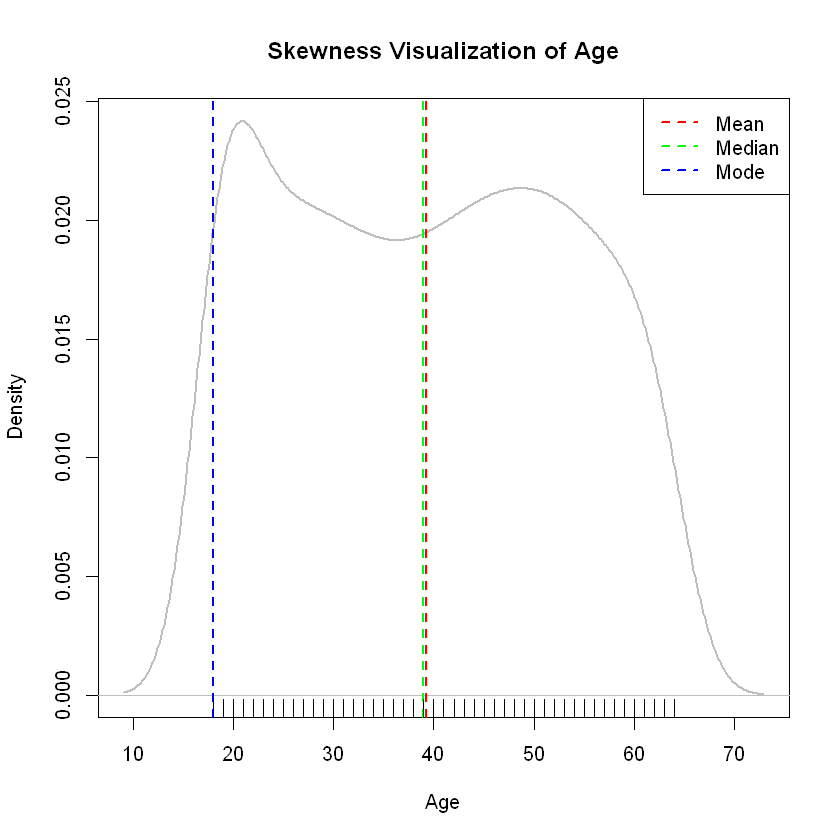

In [46]:
# Plot density plot
plot(density(data$age), 
     main = "Skewness Visualization of Age", 
     xlab = "Age", 
     ylab = "Density", 
     col = "gray", 
     lwd = 2)

# Add vertical lines for mean, median, mode
abline(v = mean_age, col = "red", lwd = 2, lty = 2)
abline(v = median_age, col = "green", lwd = 2, lty = 2)
abline(v = mode_age, col = "blue", lwd = 2, lty = 2)

# Add legend
legend("topright", 
       legend = c("Mean", "Median", "Mode"), 
       col = c("red", "green", "blue"), 
       lty = 2, 
       lwd = 2)

# Optional: add rug plot (marks on x-axis)
rug(data$age)

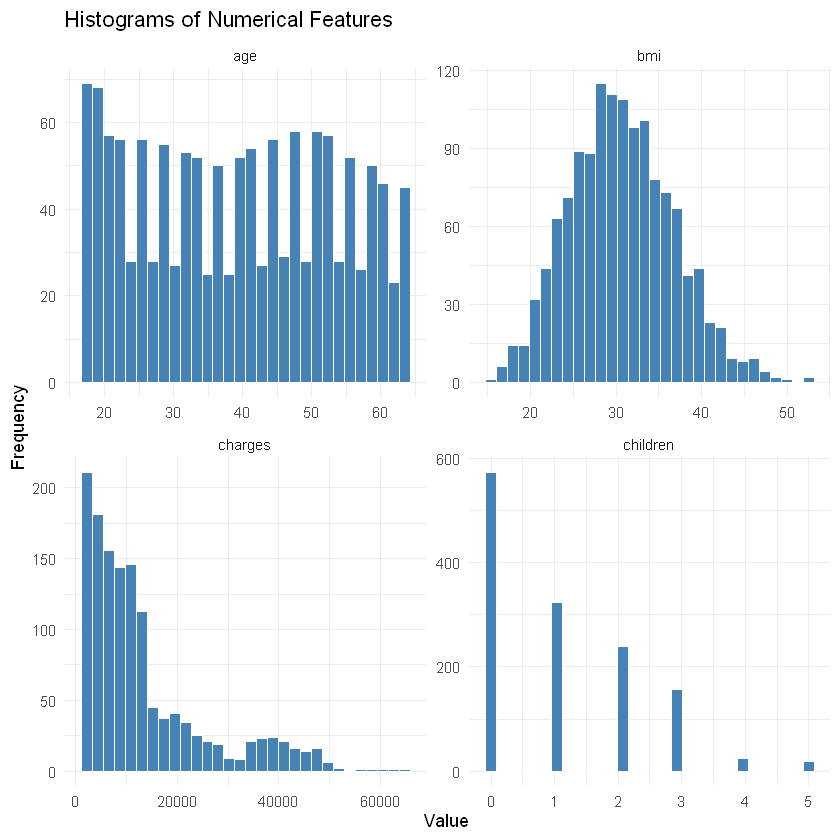

In [47]:
data %>%
  select(age, bmi, children, charges) %>%
  pivot_longer(cols = everything(), names_to = "Feature", values_to = "Value") %>%
  ggplot(aes(x = Value)) +
  facet_wrap(~ Feature, scales = "free", ncol = 2) +
  geom_histogram(fill = "steelblue", color = "white", bins = 30) +
  theme_minimal() +
  labs(title = "Histograms of Numerical Features",
       x = "Value", y = "Frequency")

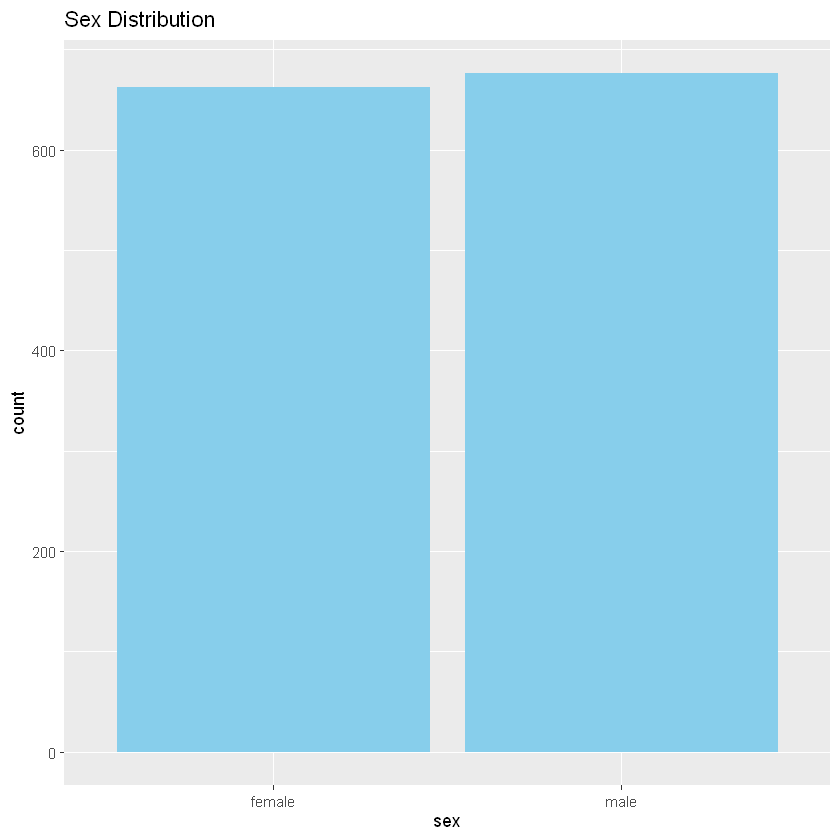

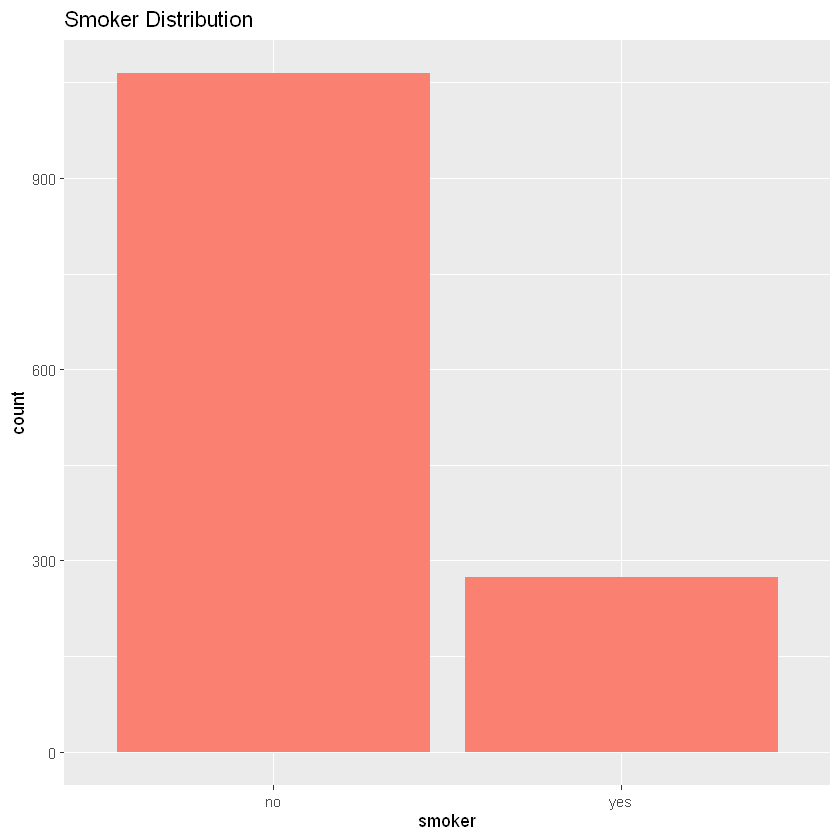

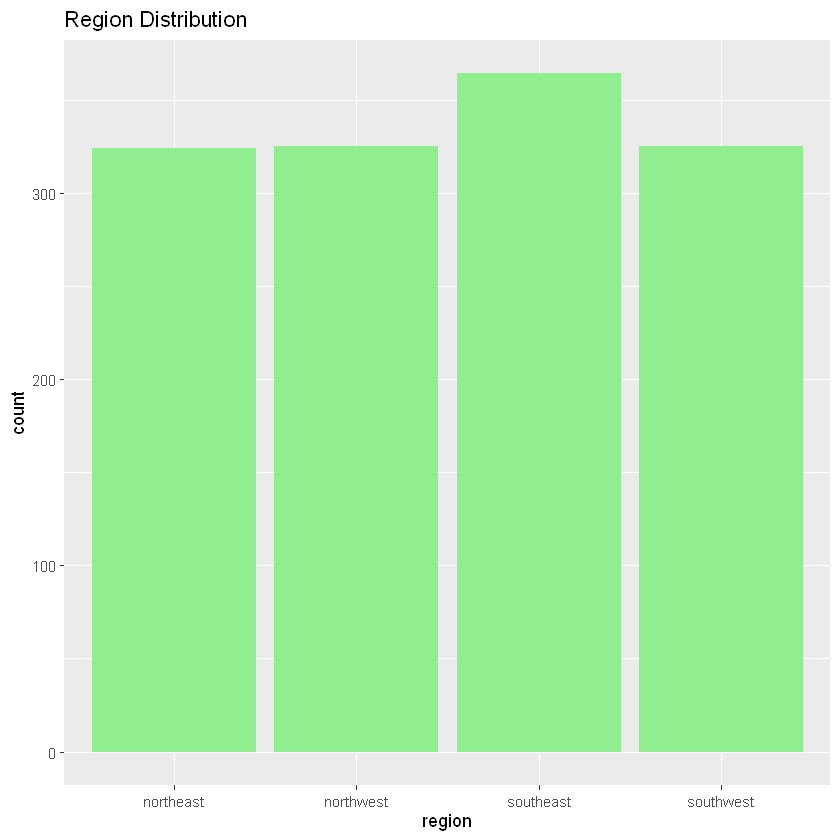

In [48]:
# Bar plots for categorical features
ggplot(data, aes(x = sex)) + geom_bar(fill = "skyblue") + ggtitle("Sex Distribution")
ggplot(data, aes(x = smoker)) + geom_bar(fill = "salmon") + ggtitle("Smoker Distribution")
ggplot(data, aes(x = region)) + geom_bar(fill = "lightgreen") + ggtitle("Region Distribution")

## 3.2Bivariate Analysis

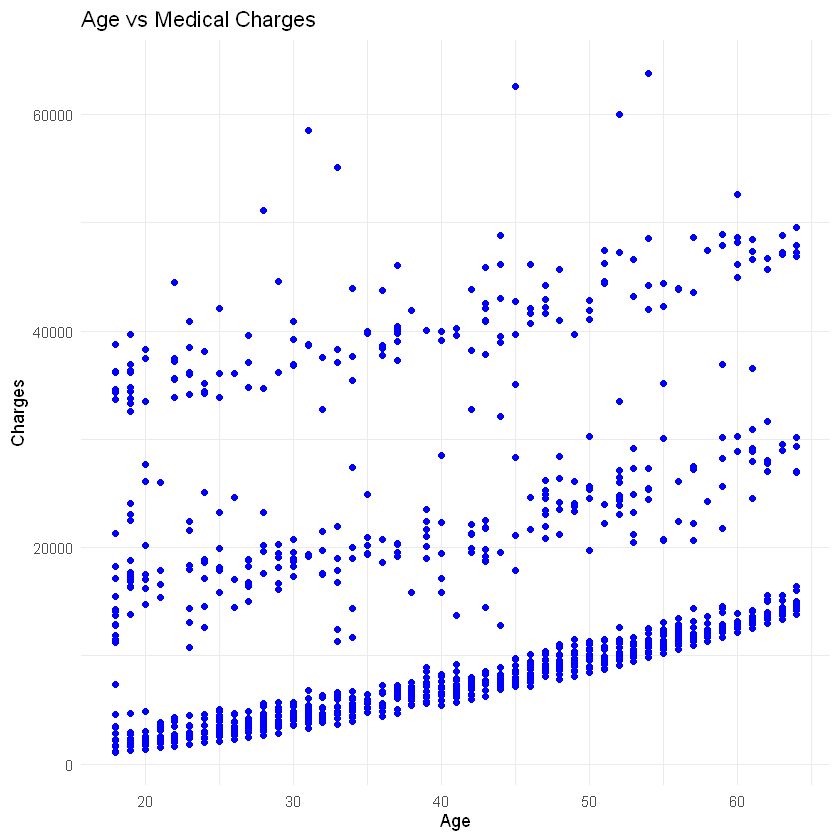

In [49]:
# Plot: Age Vs Charges

ggplot(data, aes(x = age, y = charges)) + 
    geom_point(color = 'blue') +
    labs(title = 'Age vs Medical Charges',
         x = 'Age',
         y = 'Charges') +
    theme_minimal()

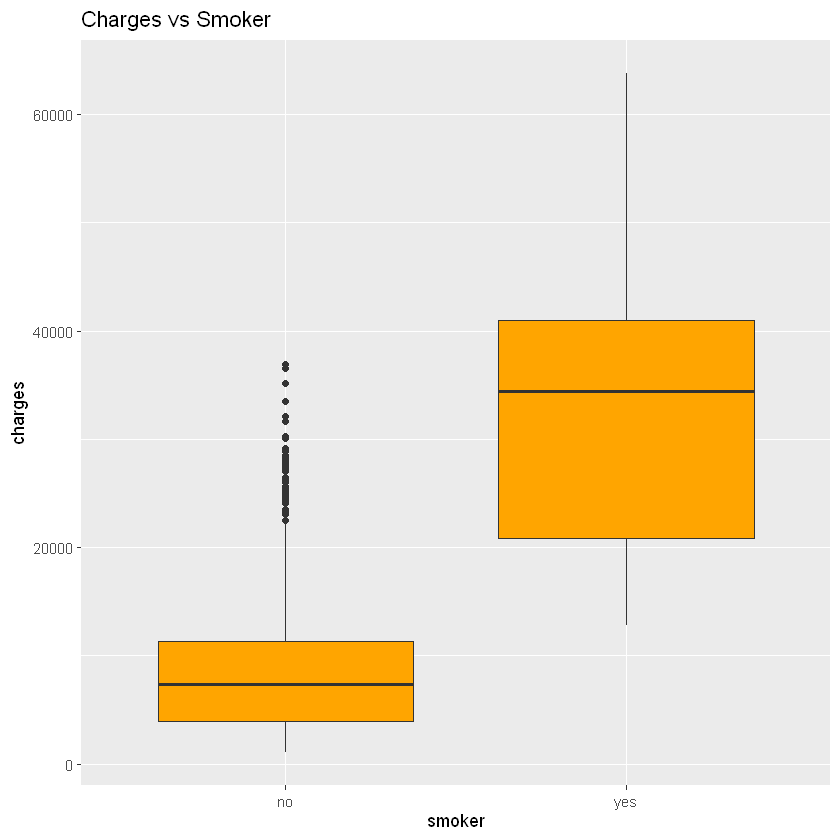

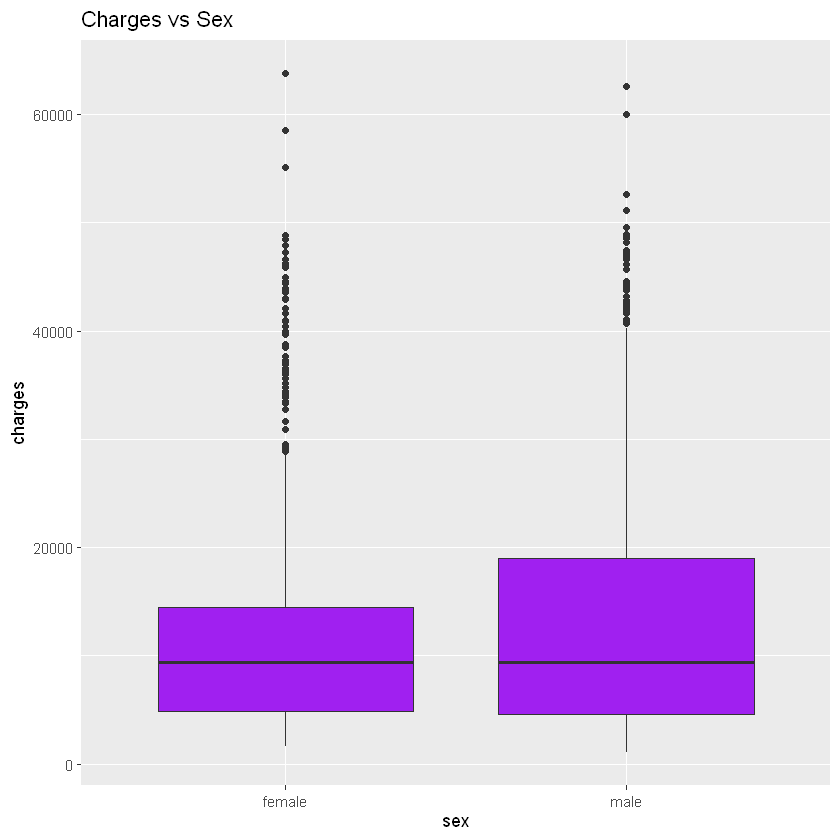

In [50]:
# Boxplots: Charges vs categorical
ggplot(data, aes(x = smoker, y = charges)) + geom_boxplot(fill = "orange") + ggtitle("Charges vs Smoker")
ggplot(data, aes(x = sex, y = charges)) + geom_boxplot(fill = "purple") + ggtitle("Charges vs Sex")

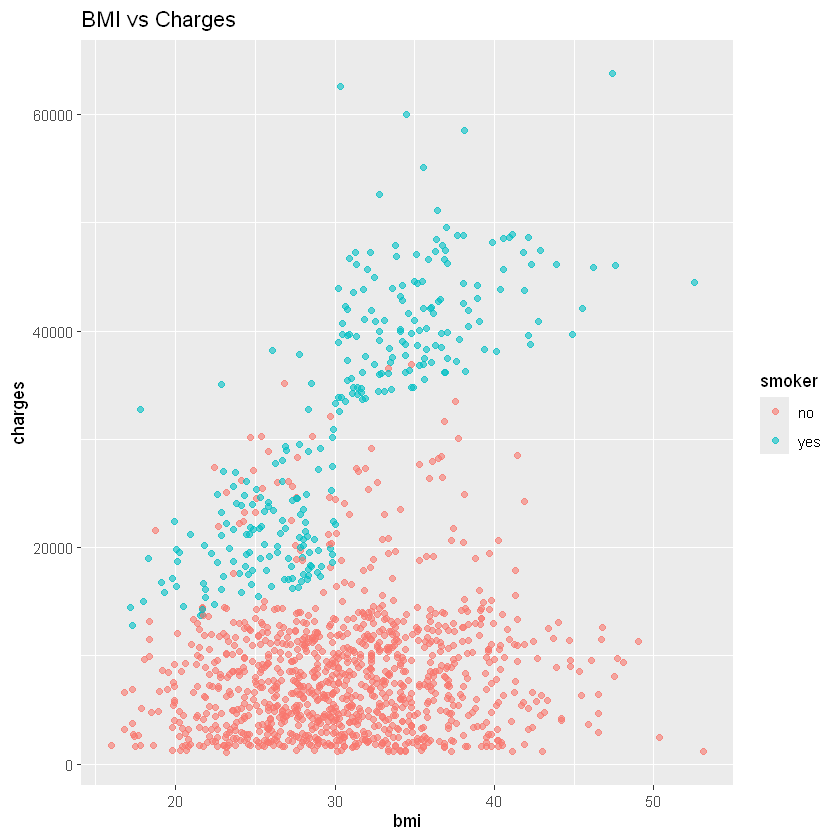

In [51]:
# Scatter plot: BMI vs Charges
ggplot(data, aes(x = bmi, y = charges, color = smoker)) +
  geom_point(alpha = 0.6) + ggtitle("BMI vs Charges")

In [52]:
# Correlation matrix for numeric columns
# Calculate correlation matrix
cor_matrix <- cor(data[num_cols])
# Print the matrix as numbers
print(cor_matrix)

               age       bmi   children    charges
age      1.0000000 0.1092719 0.04246900 0.29900819
bmi      0.1092719 1.0000000 0.01275890 0.19834097
children 0.0424690 0.0127589 1.00000000 0.06799823
charges  0.2990082 0.1983410 0.06799823 1.00000000


## 3.3Multivariate Analysis

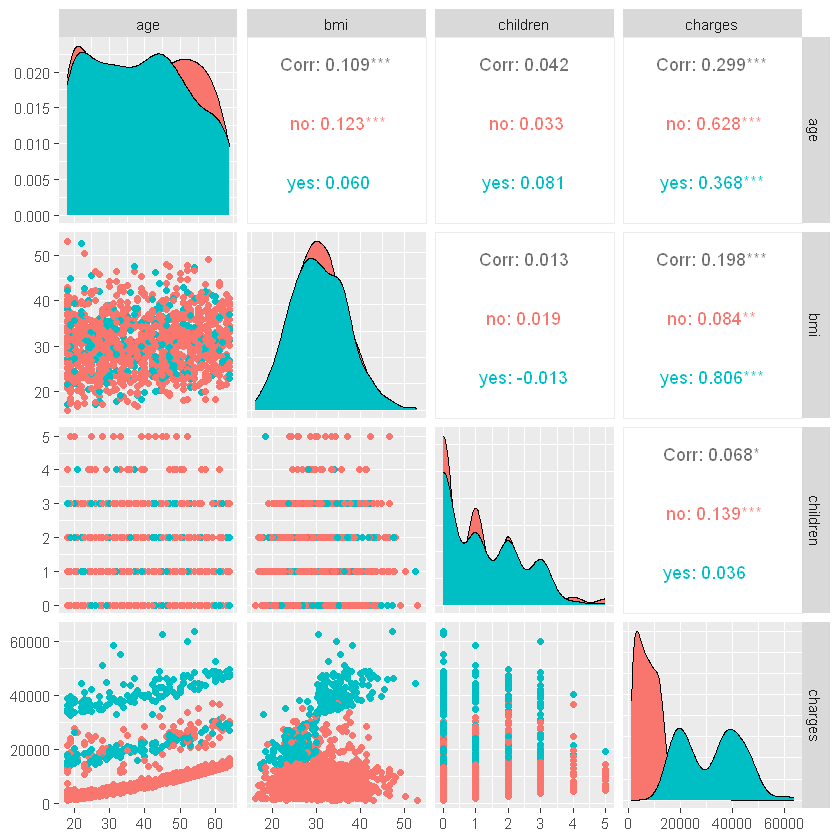

In [53]:
# Pair plot
GGally::ggpairs(data, columns = c("age", "bmi", "children", "charges"), aes(color = smoker))

# 4. Machine Learning

## 4.1Splitting the Data into Training and Testing Sets

In [54]:
# Split the data into training and testing sets (80% training, 20% testing)
set.seed(123)  # For reproducibility
split <- createDataPartition(data$charges, p = 0.8, list = FALSE)
train_data <- data[split, ]
test_data <- data[-split, ]

# Check the dimensions of the split data
dim(train_data)
dim(test_data)

[1] 1072    7

[1] 266   7

## 4.2Preprocessing the Data (Optional Scaling)

In [55]:
# Scale the numerical features (age, bmi, children, charges)
num_cols <- c("age", "bmi", "children", "charges")

# Preprocessing: Scale numeric features in training and testing sets
pre_proc <- preProcess(train_data[, num_cols], method = "scale")
saveRDS(pre_proc, "pre_proc.rds")
train_data_scaled <- predict(pre_proc, train_data[, num_cols])
test_data_scaled <- predict(pre_proc, test_data[, num_cols])

# Add back the non-numeric columns
train_data <- cbind(train_data[, setdiff(names(train_data), num_cols)], train_data_scaled)
test_data <- cbind(test_data[, setdiff(names(test_data), num_cols)], test_data_scaled)


## 4.3Training the Models

### 4.3.1Linear Regression

In [56]:
# Train a linear regression model
lm_model <- lm(charges ~ age + bmi + children + smoker + region, data = train_data)

# Make predictions on the test set
lm_predictions <- predict(lm_model, newdata = test_data)

# Evaluate the model
lm_mae <- mean(abs(lm_predictions - test_data$charges))
lm_rmse <- sqrt(mean((lm_predictions - test_data$charges)^2))
lm_r2 <- 1 - (sum((test_data$charges - lm_predictions)^2) / sum((test_data$charges - mean(test_data$charges))^2))

# Print evaluation metrics
cat("Linear Regression - MAE:", lm_mae, "\n")
cat("Linear Regression - RMSE:", lm_rmse, "\n")
cat("Linear Regression - R2:", lm_r2, "\n")

lm_r2 <- 1 - sum((test_data$charges - lm_predictions)^2) / sum((test_data$charges - mean(test_data$charges))^2)
cat("Linear Regression Accuracy (R²):", round(lm_r2, 4), "\n")


Linear Regression - MAE: 0.3429593 
Linear Regression - RMSE: 0.5153057 
Linear Regression - R2: 0.711344 
Linear Regression Accuracy (R²): 0.7113 


# Training Tree Based Models

In [57]:
data = read.csv("expenses.csv")
data$sex <- as.factor(data$sex)
data$smoker <- as.factor(data$smoker)
data$region <- as.factor(data$region)

set.seed(123)
split <- createDataPartition(data$charges, p = 0.8, list = FALSE)

train_data <- data[split, ]
test_data <- data[-split, ]
# Check the dimensions of the split data
dim(train_data)
dim(test_data)

[1] 1072    7

[1] 266   7

### 4.3.2Decision Tree

In [58]:
# Train a decision tree model
dt_model <- rpart(charges ~ age + bmi + children + smoker + region, data = train_data)

# Make predictions on the test set
dt_predictions <- predict(dt_model, newdata = test_data)

# Evaluate the model
dt_mae <- mean(abs(dt_predictions - test_data$charges))
dt_rmse <- sqrt(mean((dt_predictions - test_data$charges)^2))
dt_r2 <- 1 - (sum((test_data$charges - dt_predictions)^2) / sum((test_data$charges - mean(test_data$charges))^2))

# Print evaluation metrics
cat("Decision Tree - MAE:", dt_mae, "\n")
cat("Decision Tree - RMSE:", dt_rmse, "\n")
cat("Decision Tree - R2:", dt_r2, "\n")

dt_r2 <- 1 - sum((test_data$charges - dt_predictions)^2) / sum((test_data$charges - mean(test_data$charges))^2)
cat("Decision Tree Accuracy (R²):", round(dt_r2, 4), "\n")


Decision Tree - MAE: 3407.539 
Decision Tree - RMSE: 5316.753 
Decision Tree - R2: 0.7937918 
Decision Tree Accuracy (R²): 0.7938 


### 4.3.3Random Forest

In [59]:
# Train a random forest model
rf_model <- randomForest(charges ~ age + bmi + children + smoker + region, data = train_data)

# Make predictions on the test set
rf_predictions <- predict(rf_model, newdata = test_data)

# Evaluate the model
rf_mae <- mean(abs(rf_predictions - test_data$charges))
rf_rmse <- sqrt(mean((rf_predictions - test_data$charges)^2))
rf_r2 <- 1 - (sum((test_data$charges - rf_predictions)^2) / sum((test_data$charges - mean(test_data$charges))^2))

# Print evaluation metrics
cat("Random Forest - MAE:", rf_mae, "\n")
cat("Random Forest - RMSE:", rf_rmse, "\n")
cat("Random Forest - R2:", rf_r2, "\n")


rf_r2 <- 1 - sum((test_data$charges - rf_predictions)^2) / sum((test_data$charges - mean(test_data$charges))^2)
cat("Random Forest Accuracy (R²):", round(rf_r2, 4), "\n")



Random Forest - MAE: 4265.251 
Random Forest - RMSE: 5962.713 
Random Forest - R2: 0.7406413 
Random Forest Accuracy (R²): 0.7406 


## 4.4Model Comparison

In [60]:
# Create a summary table for model comparison
model_comparison <- data.frame(
  Model = c("Linear Regression", "Decision Tree", "Random Forest"),
  MAE = c(lm_mae, dt_mae, rf_mae),
  RMSE = c(lm_rmse, dt_rmse, rf_rmse),
  R2 = c(lm_r2, dt_r2, rf_r2)
)

# Print model comparison table
print(model_comparison)


              Model          MAE         RMSE        R2
1 Linear Regression    0.3429593    0.5153057 0.7113440
2     Decision Tree 3407.5392637 5316.7531169 0.7937918
3     Random Forest 4265.2513368 5962.7134161 0.7406413


# Saving the Models

In [61]:
#Saving the Random Forest and Decision Tree Model
saveRDS(rf_model, "model_rf.rds")
saveRDS(dt_model, "model_dt.rds")